In [1]:
from Models.BaseCNN import BaseCNN
from train_eval import trainNN, validateNN, train_and_validateNN, testNN
# from earlystop import EarlyStopper
from processes import initModel, trainModel, loadModel, plotTrain
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim

## **Data Preparation**

In [2]:
# Read in data
img_size = 224
data_transformation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root='lung_colon_image_set', transform=data_transformation)

In [3]:
dataset.class_to_idx

{'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}

In [4]:
# Set up train and test data
train_size = int(0.7 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size = int(0.1 * len(dataset))
train_data, valid_data, test_data = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

batch_size = 32  
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

len(train_data), len(valid_data), len(test_data)

(17500, 5000, 2500)

In [5]:
# 'Colon Adenocarcinoma', 'Colon Benign', 'Lung Adenocarcinoma', 'Lung Benign', 'Lung Squamous Cell Caricnoma'
classes = ('colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc')
#classes = ('lung_aca', 'lung_n', 'lung_scc')
# The function to show an image.
def display_img(ax, img, label):
    img = np.transpose(img.numpy(), (1, 2, 0))  # Change from (C,H,W) to (H,W,C)
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    img = stds * img + means  # Apply the reverse of normalization     # Unnormalize.
    img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
    ax.imshow(img)
    ax.set_title(classes[label])
    ax.axis('off')

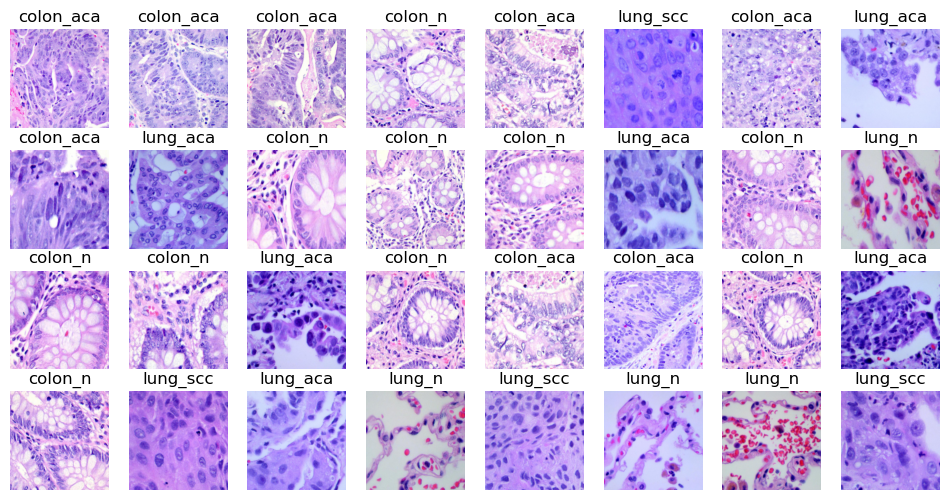

In [6]:
plt.figure(figsize=(12, 6))

# Get a random batch of training images.
images, labels = next(iter(train_loader))

for i in range(batch_size):
    ax = plt.subplot(4, 8, i+1)  # Create a subplot for each image
    display_img(ax, images[i], labels[i])

In [7]:
# Set up device
if torch.backends.mps.is_available(): # M1 Mac
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)  

mps


## **Set Up Training and Validation Steps**

In [8]:
num_epochs = 1
criterion = nn.CrossEntropyLoss()
lr = 0.001

In [9]:
def w_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0, .02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1, .02)
        nn.init.constant_(m.bias.data, 0)

### ReLU + MaxPool

In [10]:
model = initModel('relu', 'max', img_size, device, elu_val = 1, lrelu_val = .01)
model.apply(w_init)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, 'relu', 'max', img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

[Epoch 1/1]
Mini-batch (i: 100): Average mini-batch loss: 0.632
Mini-batch (i: 200): Average mini-batch loss: 0.474
Mini-batch (i: 300): Average mini-batch loss: 0.421
Mini-batch (i: 400): Average mini-batch loss: 0.373
Mini-batch (i: 500): Average mini-batch loss: 0.349
End of Epoch 1 - train loss: 0.4379, valid loss: 0.9502
Finished Training.


In [15]:
# plotTrain(train_loss, valid_loss)

In [11]:
_,_ = testNN(model, test_loader, classes, device)

tensor([0, 3, 0, 4, 0, 3, 3, 0, 0, 4, 4, 0, 4, 0, 3, 0, 4, 1, 0, 0, 4, 4, 4, 4,
        4, 0, 4, 4, 3, 4, 4, 3], device='mps:0')
tensor([0, 0, 0, 4, 2, 4, 0, 1, 4, 3, 4, 4, 4, 3, 3, 1, 0, 3, 4, 0, 3, 4, 0, 3,
        4, 0, 0, 0, 4, 4, 4, 0], device='mps:0')
tensor([4, 4, 4, 4, 4, 4, 0, 4, 0, 0, 0, 0, 4, 3, 4, 4, 4, 0, 0, 1, 0, 4, 4, 4,
        0, 3, 0, 0, 4, 0, 4, 1], device='mps:0')
tensor([0, 0, 3, 3, 4, 4, 0, 4, 4, 0, 4, 1, 0, 4, 0, 3, 3, 3, 4, 3, 0, 4, 0, 4,
        3, 0, 3, 4, 4, 4, 4, 0], device='mps:0')
tensor([1, 4, 3, 4, 0, 4, 4, 4, 3, 4, 4, 4, 3, 1, 0, 4, 0, 4, 4, 0, 3, 4, 4, 3,
        1, 3, 3, 4, 4, 2, 1, 3], device='mps:0')
tensor([1, 4, 4, 4, 4, 1, 4, 4, 0, 4, 4, 3, 0, 4, 0, 4, 1, 4, 4, 0, 0, 4, 0, 0,
        0, 0, 1, 0, 4, 4, 0, 4], device='mps:0')
tensor([3, 4, 3, 2, 3, 0, 0, 0, 3, 0, 4, 4, 0, 1, 4, 2, 0, 4, 0, 0, 4, 0, 4, 3,
        3, 4, 0, 4, 0, 0, 3, 3], device='mps:0')
tensor([1, 4, 3, 3, 0, 4, 3, 0, 0, 4, 4, 4, 4, 4, 3, 2, 4, 3, 4, 0, 0, 0, 0, 0,
        3, 0, 0, 

### ReLU + AvgPool

In [ ]:
model = initModel('relu', 'avg', img_size, device, elu_val = 1, lrelu_val = .01)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, 'relu', 'avg', img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

In [ ]:
plotTrain(train_loss, valid_loss)

### LeakyReLU + MaxPool

In [ ]:
model = initModel('lrelu', 'max', img_size, device, elu_val = 1, lrelu_val = .01)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, 'lrelu', 'max', img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

In [ ]:
plotTrain(train_loss, valid_loss)

### LeakyReLU + AvgPool

In [ ]:
model = initModel('relu', 'avg', img_size, device, elu_val = 1, lrelu_val = .01)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, 'lrelu', 'avg', img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

In [ ]:
plotTrain(train_loss, valid_loss)

### ELU + MaxPool

In [ ]:
model = initModel('elu', 'max', img_size, device, elu_val = 1, lrelu_val = .01)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, 'elu', 'max', img_size, train_loader, valid_loader, criterion, optimizer, device)

In [ ]:
plotTrain(train_loss, valid_loss)

### ELU + AvgPool

In [ ]:
model = initModel('elu', 'avg', img_size, device, elu_val = 1, lrelu_val = .01)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, 'elu', 'avg', img_size, train_loader, valid_loader, criterion, optimizer, device)

In [ ]:
plotTrain(train_loss, valid_loss)

## **Evaluate on Testing Data**

### ReLU + MaxPool

In [ ]:
loadModel('relu', 'max', img_size, test_loader, classes, device)

### ReLU + AvgPool

In [ ]:
loadModel('relu', 'avg', img_size, test_loader, classes, device)

### LeakyReLU + MaxPool

In [ ]:
loadModel('lrelu', 'max', img_size, test_loader, classes, device)

### LeakyReLU + AvgPool

In [ ]:
loadModel('lrelu', 'avg', img_size, test_loader, classes, device)

### ELU + MaxPool

In [ ]:
loadModel('elu', 'max', img_size, test_loader, classes, device)

### ELU + AvgPool

In [ ]:
loadModel('elu', 'avg', img_size, test_loader, classes, device)

## **Comparison to other popular CNN Architectures**

Any other popular architectures (feel free to edit / we can decide together)